In [9]:
%matplotlib inline
import spotipy
import pandas as pd
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException

pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', False)

In [10]:
# Logging in
username = "113586775"

spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

In [11]:
# Which tracks was released in 2018?
release_date = []
artist_name = []
track_name = []
popularity = []
track_id = []

for i in range(0,10000,50):
    try:
        track_results = spotify.search(q='year:2018', type='track', limit=50, offset=i)
    except SpotifyException as err:
        print(i, err)
        break
        # Ignore 404 HTTP error

    if track_results is None:
        break

    for t in track_results['tracks']['items']:
        release_date.append(t['album']['release_date'])
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])

print("Number of tracks: ", len(track_id))

HTTP Error for GET to https://api.spotify.com/v1/search with Params: {'q': 'year:2018', 'limit': 50, 'offset': 1000, 'type': 'track', 'market': None} returned 400 due to Bad request.


1000 http status: 400, code:-1 - https://api.spotify.com/v1/search?q=year%3A2018&limit=50&offset=1000&type=track:
 Bad request., reason: None
Number of tracks:  1000


In [12]:
# Creating a dataframe
track_df = pd.DataFrame(
    {
        'release_date': release_date,
        'artist_name': artist_name,
        'track_name': track_name,
        'track_id': track_id,
        'popularity': popularity
    }
)
track_df['release_date'] = pd.to_datetime(track_df['release_date'], format="mixed")
track_df.sort_values(by=['release_date', 'artist_name', 'track_name'], inplace=True, ignore_index=True)
# ignore_index=True: updates the indices of the dataframe

print(f"Dataframe shape: {track_df.shape}")
print("\n", track_df.head(10))
print("\n", track_df.describe())
print("\n", track_df.dtypes)

Dataframe shape: (1000, 5)

   release_date  artist_name  track_name                track_id  popularity
0   2018-01-01      6ix9ine        BEBE  3eqOaTqnyb0GEgv6JInG6W          73
1   2018-01-01      6ix9ine        FEFE  1M6SuEJZJkZf2S419vIPkB          72
2   2018-01-01      6ix9ine        MALA  4epHhc2lvhFYzMlKA23O3G          79
3   2018-01-01      6ix9ine        WAKA  6ZyjQTlZxDtdjYKDwcAWNk          63
4   2018-01-01  Beach Bunny      Sports  77G0k1La0c5Dw8bAFANcyp          73
5   2018-01-01     Cavetown        Fool  7asyVbwQE7IbA3x2be7bdI          65
6   2018-01-01     Cavetown   Lemon Boy  3Yvk0ZLxMlt6ioasvdN6vB          67
7   2018-01-01    Vacations       Honey  7IBzp33O4Hjr92wXtH3yQJ          69
8   2018-01-01    Vacations  Telephones  0JIMT9gzLIIz0esKLyjbKf          82
9   2018-01-06  Omar Apollo  Unbothered  3pBG8fHFEUp3edhWfkIoCW          61

                      release_date   popularity
count                        1000  1000.000000
mean   2018-07-14 13:20:38.400000    69

No. artists:  459


array([[<Axes: title={'center': 'popularity'}>]], dtype=object)

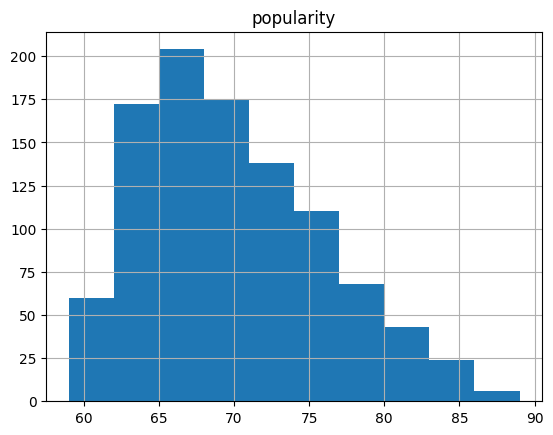

In [13]:
print("No. artists: ", track_df['artist_name'].nunique())

track_df.hist(column='popularity')

In [14]:
# Which playlists do I have?
playlists = spotify.user_playlists(username)
if playlists is None:
    print("playlists is None")
    exit(1)
print("Type: ", type(playlists))
print("Keys: ", playlists.keys())
print()

playlist_name = []
playlist_ntracks = []
playlist_id = []

for p in playlists['items']:
    playlist_name.append(p['name'])
    playlist_ntracks.append(p['tracks']['total'])
    playlist_id.append(p['id'])

playlist_df = pd.DataFrame(
    {'n_tracks': playlist_ntracks, 'id': playlist_id}, 
    index=playlist_name
    )
print(playlist_df)
print("Number of tracks in Favorites-playlist: ", playlist_df['n_tracks']['Favorites'])

Type:  <class 'dict'>
Keys:  dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])

                                n_tracks                      id
Favorites                           1178  2tvrDqnp3vJd6l6Cw38bVZ
Queen and other classics             107  367BXl0oqvDSbBu34T6OBH
John Mayer                           224  4h69xgBmpi8WnrCzNG0saL
Top 50 - Global                       50  37i9dQZEVXbMDoHDwVN2tF
Rock and other hard materials         86  2k19D3M2QSz3sdS0MzocSs
Party                                479  1Vs71OxUMfNXTLtp4USgTA
Blues                                 49  5na5MdXxNrFa7JUUwg14qP
Piano                                 32  4qa6CoQZqpUun4Divl1Cjg
VOLUME DENMARK                        80  37i9dQZF1DXcSNirXzsHRX
Tolkiens The Lord of the Ri...        78  4F3VK81yAvFlVquazfxVLG
Number of tracks in Favorites-playlist:  1178


In [15]:
artists = []
unique_artists = []
track_name = []
release_date = []
popularity = []
track_id = []
duration_ms = []

for i in range(0, playlist_df['n_tracks'].Favorites, 100):
    track_results = spotify.user_playlist_tracks(username, playlist_df['id'].Favorites, offset=i, limit=100)

    if track_results is None:
        print("track_results is None")
        break

    for track in track_results['items']:
        artists.append({artist['name'] for artist in track['track']['artists']})
        
        for artist in track['track']['artists']:
            if artist['name'] not in unique_artists:
                unique_artists.append(artist['name'])
        track_name.append(track['track']['name'])
        release_date.append(track['track']['album']['release_date'])
        popularity.append(track['track']['popularity'])
        track_id.append(track['track']['id'])
        duration_ms.append(track['track']['duration_ms'])

In [16]:
artists_df = pd.DataFrame(artists, columns=[f"artist_{i + 1}" for i in range(max(map(len, artists)))])

favorites_df = pd.DataFrame(
    {
        'release_date': release_date,
        'track_name': track_name,
        'popularity': popularity,
        'track_id': track_id,
        'duration_ms': duration_ms
    }
)
favorites_df['release_date'] = pd.to_datetime(favorites_df['release_date'], format="mixed")

favorites_df = pd.concat([favorites_df, artists_df], axis=1)
favorites_df.sort_values(by='release_date', inplace=True, ascending=False, ignore_index=True)
favorites_df

,release_date,track_name,popularity,track_id,duration_ms,artist_1,artist_2,artist_3,artist_4,artist_5,artist_6
0,2023-02-10,Borderline,73,164QjgWOxnSZYHQghRKeC0,193381,Tove Lo,None,None,None,None,None
1,2022-10-14,2 Die 4,65,71BJVUm9wse1WBFEGHIFsI,185875,Tove Lo,None,None,None,None,None
2,2022-09-22,Unholy (feat. Kim Petras),93,3nqQXoyQOWXiESFLlDF1hG,156943,Kim Petras,Sam Smith,None,None,None,None
3,2022-08-19,Wish You Were Here (feat. ...,54,7w75srYPbm2wIbrPDgfCLH,175698,Khalid,Lukas Graham,None,None,None,None
4,2022-08-19,hvad skal verden med sådan...,57,3lt2vb4iuIJrvIccs2IlBU,166000,andreas odbjerg,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1173,1970-04-10,Your Song,0,17VegeBoHvMlIByrdu64KR,244226,Elton John,None,None,None,None,None
1174,1968-11-22,While My Guitar Gently Wee...,0,4J4gApJKSC0himDViFotdy,285000,The Beatles,None,None,None,None,None
1175,1968-11-22,Blackbird - Remastered,0,4Z92RMiyJpUrApZi3LtpJ6,138386,The Beatles,None,None,None,None,None
1176,1968-10-25,All Along the Watchtower,77,2aoo2jlRnM3A0NyLQqMN2f,240800,Jimi Hendrix,None,None,None,None,None


,release_date,track_name,artist_1,artist_2,artist_3,artist_4,artist_5,artist_6,popularity,duration_ms,track_id
0,2023-02-10,Borderline,Tove Lo,None,None,None,None,None,73,193381,164QjgWOxnSZYHQghRKeC0
1,2022-10-14,2 Die 4,Tove Lo,None,None,None,None,None,65,185875,71BJVUm9wse1WBFEGHIFsI
2,2022-09-22,Unholy (feat. Kim Petras),Kim Petras,Sam Smith,None,None,None,None,93,156943,3nqQXoyQOWXiESFLlDF1hG
3,2022-08-19,Wish You Were Here (feat. ...,Khalid,Lukas Graham,None,None,None,None,54,175698,7w75srYPbm2wIbrPDgfCLH
4,2022-08-19,hvad skal verden med sådan...,andreas odbjerg,None,None,None,None,None,57,166000,3lt2vb4iuIJrvIccs2IlBU
...,...,...,...,...,...,...,...,...,...,...,...
1173,1970-04-10,Your Song,Elton John,None,None,None,None,None,0,244226,17VegeBoHvMlIByrdu64KR
1174,1968-11-22,While My Guitar Gently Wee...,The Beatles,None,None,None,None,None,0,285000,4J4gApJKSC0himDViFotdy
1175,1968-11-22,Blackbird - Remastered,The Beatles,None,None,None,None,None,0,138386,4Z92RMiyJpUrApZi3LtpJ6
1176,1968-10-25,All Along the Watchtower,Jimi Hendrix,None,None,None,None,None,77,240800,2aoo2jlRnM3A0NyLQqMN2f


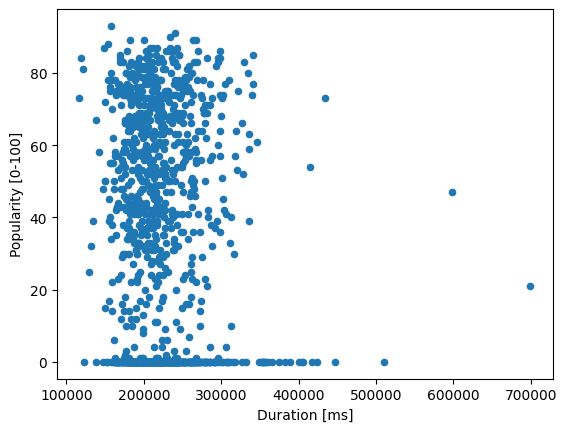

In [17]:
cols = [
    'release_date',
    'track_name',
    'artist_1',
    'artist_2',
    'artist_3',
    'artist_4',
    'artist_5',
    'artist_6',
    'popularity',
    'duration_ms',
    'track_id'
]
favorites_df = favorites_df[cols]

favorites_df.plot.scatter(
    x='duration_ms', y='popularity', 
    xlabel='Duration [ms]', ylabel='Popularity [0-100]'
)

favorites_df

In [18]:
favorites_df.groupby(['artist_1', 'artist_2']).popularity.count()

artist_1      artist_2         
21 Savage     Post Malone          1
3 Doors Down  Bob Seger            1
              Jack Joseph Puig     5
A7S           Topic                1
AFROJACK      Bebe Rexha           1
                                  ..
kai           Flume                1
mansionz      Spark Master Tape    1
shy martin    Mike Perry           1
slowthai      Mura Masa            1
will.i.am     The Script           1
Name: popularity, Length: 296, dtype: int64

In [19]:
favorites_df.groupby('artist_1').popularity.agg([len, min, max])

,len,min,max
artist_1,,,
21 Savage,1,1,1
3 Doors Down,14,0,54
5 Seconds of Summer,3,68,81
A Tribe Called Quest,1,54,54
A7S,1,77,77
...,...,...,...
mags,1,15,15
mansionz,1,0,0
shy martin,1,71,71
